In [1]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.2 MB/s eta 0:00:00


In [2]:
!pip install persim

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.1 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=a83b6c5fe4f559648cc7ae8999d55e4352ecfaad699af273aec5420f41d5908b
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [3]:
!pip install ripser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 9.2 MB/s eta 0:00:00


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import  DBSCAN
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.preprocessing import StandardScaler
import networkx as nx  # to draw graphs
from ripser import Rips   # to compute the topological diagrams
from persim import plot_diagrams  # to plot the topological diagrams
import warnings
warnings.filterwarnings("ignore")

In [70]:
train = pd.read_csv("/content/proteinas_train.csv")
test = pd.read_csv("/content/proteinas_test.csv")
df = pd.concat([train, test], ignore_index=True)
df.head()

,ID_Proteína,Sequência,Massa_Molecular,Ponto_Isoelétrico,Hidrofobicidade,Carga_Total,Proporção_Polar,Proporção_Apolar,Comprimento_Sequência,Classe
0,TRAIN_P00001,GNMRFVLHDEETHWGTLRTTLNCVPSDIYTISGEDSLFWGMAHPFC...,20362.9468,4.866123,0.149425,-3,0.241379,0.408046,174,Estrutural
1,TRAIN_P00002,LFKMQCSFYLLYLAKEAASYQVSMNMLCYEWYNYVYQVTVILRLSR...,9328.7909,6.298636,0.217105,0,0.210526,0.513158,76,Estrutural
2,TRAIN_P00003,PAHLWPYWRFYVWIVFYGYHNPNYHFGMKEVKERPDCKNCTVAVLF...,17616.3852,8.458977,0.192568,8,0.141892,0.466216,148,Estrutural
3,TRAIN_P00004,GEAFSRPHCFACAATKKGFPWARMCCTTSMAMDGVQSKMHKSKHRF...,35244.2968,8.448340,0.160473,21,0.189189,0.408784,296,Estrutural
4,TRAIN_P00005,HYVFQGLMLHCGGYMITACGFGVIFPEQMTREGLIMHTARAHHFLI...,34557.9931,7.696306,0.140411,18,0.202055,0.380137,292,Receptora


In [71]:
protein = df['Sequência']
protein.head()

,Sequência
0,GNMRFVLHDEETHWGTLRTTLNCVPSDIYTISGEDSLFWGMAHPFC...
1,LFKMQCSFYLLYLAKEAASYQVSMNMLCYEWYNYVYQVTVILRLSR...
2,PAHLWPYWRFYVWIVFYGYHNPNYHFGMKEVKERPDCKNCTVAVLF...
3,GEAFSRPHCFACAATKKGFPWARMCCTTSMAMDGVQSKMHKSKHRF...
4,HYVFQGLMLHCGGYMITACGFGVIFPEQMTREGLIMHTARAHHFLI...


In [72]:
#The function returns 0 is there is an unambigous letter, and 1 otherwise.
def unambigous_checker(protein):
    Unambiguous_Letters=['B', 'Z', 'X', 'J']# unvalid unambiguous letter for protein
    Letters=list(protein)# get the letters from the protein
    dic={}
    checker=1
    for acid in Letters:
        if acid in Unambiguous_Letters:
            dic[acid]=0
        else:
            dic[acid]=1

        checker= checker*dic[acid]
    return checker


# Test on the data
N=len(protein)
check=np.zeros(N)
for i in range(N):
    check[i]=unambigous_checker(protein[i])

print('There is exactly ', N-sum(check), 'protein(s) with at least one unambigous letter')

There is exactly  0.0 protein(s) with at least one unambigous letter


**Feature extraction from protein parametric information**

We extract features by analysing different properties of each protein of the data. These are: amino acid frequences per proteins, molecular weight, aromaticity, instability_index, flexibility, isoelectric point, secondary structure fraction, and the protein scaling. We use the methods defined in the ProtParam module of Biopython.

In [73]:
def amino_acid_features(data):
    N=len(data)
    # Creating the alphabet
    Alphabet=list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    # Create feature names
    Acid_Features=[Alphabet[i]+'_feature' for i in range(len(Alphabet))]
    # Initialize the dataframe with amino acid features
    matrix=np.zeros((N, 26))
    df=pd.DataFrame(matrix, columns=Alphabet)
    for i in range(N):
        my_seq=data[i]
        analysed_seq = ProteinAnalysis(my_seq)
        count= analysed_seq.count_amino_acids()# Count the amino acids
        Names=[name for name in count] # Get the amino acids present in the protein
        for acid in Names:
            df[acid][i]=count[acid]
    # Renaming dataframe columns
    df.columns=Acid_Features
    return df
# Test on the data
df_Amino_acid=amino_acid_features(protein)
print(df_Amino_acid)

       A_feature  B_feature  C_feature  D_feature  E_feature  F_feature  \
0            7.0        0.0        8.0       13.0        6.0        9.0   
1            4.0        0.0        8.0        1.0        5.0        4.0   
2            9.0        0.0        9.0        7.0        5.0       10.0   
3           21.0        0.0       20.0       17.0        9.0       25.0   
4           12.0        0.0       12.0       11.0       18.0       19.0   
...          ...        ...        ...        ...        ...        ...   
19995       10.0        0.0        7.0        6.0        7.0       11.0   
19996       10.0        0.0       13.0       17.0       14.0       15.0   
19997       10.0        0.0        9.0       13.0       12.0       15.0   
19998       17.0        0.0       12.0       14.0       13.0        8.0   
19999        1.0        0.0        1.0        3.0        3.0        5.0   

       G_feature  H_feature  I_feature  J_feature  ...  Q_feature  R_feature  \
0           10.0   

In [74]:
# Get the molecular weight of the protein
def protein_weight_feature(data):
    N=len(data)
    weight=np.zeros(N)
    for i in range(N):
        my_seq=data[i]
        analysed_seq=ProteinAnalysis(my_seq)
        if unambigous_checker(my_seq)==1: # Check is the data has a protein with unambigous letter
            weight[i]=analysed_seq.molecular_weight() # get the weight of the protein
    return weight

# Test on the data
weight=protein_weight_feature(protein)
print(pd.DataFrame(weight) )

                0
0      20362.9468
1       9328.7909
2      17616.3852
3      35244.2968
4      34557.9931
...           ...
19995  20098.1448
19996  30993.5049
19997  33456.7243
19998  31324.8672
19999   8091.1999

[20000 rows x 1 columns]


In [75]:
# Get the aromaticity of the protein
def aromaticity_feature(data):
    N=len(data)
    aromaticity=np.zeros(N)
    for i in range(N):
        my_seq=data[i]
        analysed_seq=ProteinAnalysis(my_seq)
        aromaticity[i]= analysed_seq.aromaticity()
    return aromaticity



# Test on the data
aromaticity= aromaticity_feature(protein)
print(pd.DataFrame(aromaticity))

              0
0      0.155172
1      0.223684
2      0.182432
3      0.175676
4      0.154110
...         ...
19995  0.186747
19996  0.137931
19997  0.167883
19998  0.131086
19999  0.138462

[20000 rows x 1 columns]


In [76]:
# Get the instability_index of the protein
def instability_index_Feature(data):
    N=len(data)
    instability_index=np.zeros(N)
    for i in range(N):
        my_seq=data[i]
        analysed_seq=ProteinAnalysis(my_seq)
        if unambigous_checker(my_seq)==1:# Check is the data has a protein with unambigous letter
            instability_index[i]= analysed_seq.instability_index()
    return instability_index


# Test on the data
instability_index=instability_index_Feature(protein)
print(pd.DataFrame(instability_index))

               0
0      48.983333
1      37.071184
2      48.030541
3      56.425777
4      38.801027
...          ...
19995  50.539217
19996  45.565517
19997  39.382591
19998  46.075318
19999  86.152308

[20000 rows x 1 columns]


In [77]:
# Get the flexibility mean of the protein
def flexibility_mean_feature(data):
    N=len(data)
    flexibility_mean=np.zeros(N)
    for i in range(N):
        my_seq=data[i]
        analysed_seq=ProteinAnalysis(my_seq)
        if unambigous_checker(my_seq)==1:# Check is the data has a protein with unambigous letter
            flexibility_mean[i]= np.mean(analysed_seq.flexibility())
    return flexibility_mean
# Test on the data
flexibility=flexibility_mean_feature(protein)
print(pd.DataFrame(flexibility))

              0
0      0.989079
1      0.974003
2      0.984328
3      0.987253
4      0.993377
...         ...
19995  0.986001
19996  0.989677
19997  0.993052
19998  0.998516
19999  0.996500

[20000 rows x 1 columns]


In [78]:
# Get the isoelectric point of the protein
def isoelectric_point_feature(data):
    N=len(data)
    isoelectric_point=np.zeros(N)
    for i in range(N):
        my_seq=data[i]
        analysed_seq=ProteinAnalysis(my_seq)
        isoelectric_point[i]= analysed_seq.isoelectric_point()
    return isoelectric_point
# Test on the data
isoelectric_point=isoelectric_point_feature(protein)
print(pd.DataFrame(isoelectric_point))

               0
0       4.866123
1       6.298636
2       8.458977
3       8.448340
4       7.696306
...          ...
19995   8.712789
19996   6.263623
19997   9.151948
19998   8.755596
19999  10.893110

[20000 rows x 1 columns]


In [79]:
# Get the secondary structure fraction of the protein
def secondary_structure_fraction_feature(data):
    N=len(data)
    matrix=np.zeros((N, 3))
    df=pd.DataFrame(matrix, columns=['Helix', 'Turn', 'Sheet'])
    for i in range(N):
        my_seq=data[i]
        analysed_seq=ProteinAnalysis(my_seq)
        triple= analysed_seq.secondary_structure_fraction()
        df['Helix'][i]=triple[0]
        df['Turn'][i]=triple[1]
        df['Sheet'][i]=triple[2]
    return df

# Test on the data
df_secondary_structure_fraction=secondary_structure_fraction_feature(protein)
print(df_secondary_structure_fraction)

          Helix      Turn     Sheet
0      0.224138  0.304598  0.373563
1      0.276316  0.131579  0.486842
2      0.229730  0.243243  0.398649
3      0.263514  0.250000  0.310811
4      0.253425  0.222603  0.359589
...         ...       ...       ...
19995  0.271084  0.253012  0.349398
19996  0.249042  0.260536  0.363985
19997  0.240876  0.251825  0.357664
19998  0.299625  0.277154  0.310861
19999  0.261538  0.215385  0.369231

[20000 rows x 3 columns]


In [80]:
# Get the protein scale mean of the protein
def protein_scale_mean_feature(data):
    N=len(data)
    protein_scale_mean=np.zeros(N)
    for i in range(N):
        my_seq=data[i]
        analysed_seq=ProteinAnalysis(my_seq)
        if unambigous_checker(my_seq)==1:# Check is the data has a protein with unambigous letter
            protein_scale_mean[i]= np.mean(analysed_seq.protein_scale(analysed_seq.get_amino_acids_percent(), window=9, edge=0.4))
    return protein_scale_mean
# Test on the data
protein_scale=protein_scale_mean_feature(protein)
print(pd.DataFrame(protein_scale))

              0
0      0.056649
1      0.072615
2      0.055142
3      0.055252
4      0.053450
...         ...
19995  0.055395
19996  0.053261
19997  0.052189
19998  0.053463
19999  0.070013

[20000 rows x 1 columns]


In [81]:
New_data=df_Amino_acid.copy()
New_data['weight']=weight
New_data['aromaticity']=aromaticity
New_data['instability']=instability_index
New_data['flexibility']=flexibility
New_data['isoelectric_point']=isoelectric_point
New_data['Helix']=df_secondary_structure_fraction['Helix']
New_data['Turn']=df_secondary_structure_fraction['Turn']
New_data['Sheet']=df_secondary_structure_fraction['Sheet']
New_data['protein_scale']=protein_scale
print('The new data has', New_data.shape[1], 'features.')

The new data has 35 features.


<Axes: xlabel='variance', ylabel='features'>

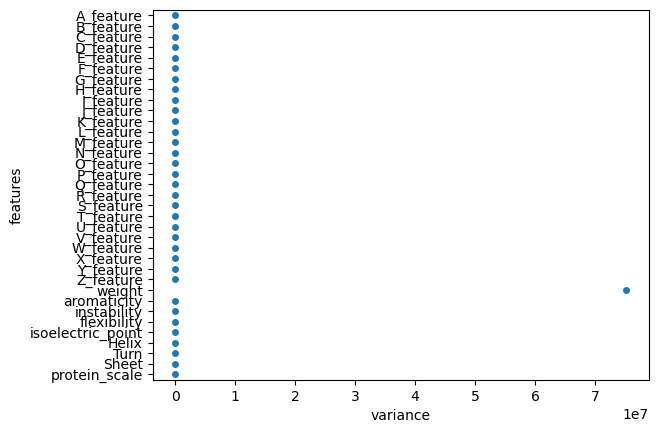

In [82]:
Covariances=New_data.cov() # Computing the covariance matrix
# Creating a dataframe with feature variances
variances=pd.DataFrame(np.diag(Covariances), index=Covariances.index, columns=['variance'])
features=list(variances.index) # Creating a feature list
variances['features']=features # Creating a feature column
sns.swarmplot(x="variance", y="features", data=variances)# Plotting the variances

<Axes: xlabel='variance', ylabel='features'>

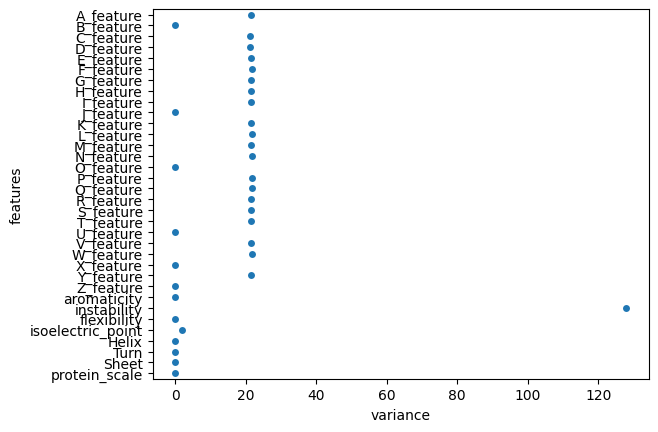

In [83]:
df=variances.drop(index='weight')# drop the feature "weight"
sns.swarmplot(x="variance", y="features", data=df)

In [84]:
Var=variances[variances.variance>0.05]
New_features=Var.index.values.tolist()
print('The features to consider in our analysis are:',New_features)
Final_data=New_data[New_features]

The features to consider in our analysis are: ['A_feature', 'C_feature', 'D_feature', 'E_feature', 'F_feature', 'G_feature', 'H_feature', 'I_feature', 'K_feature', 'L_feature', 'M_feature', 'N_feature', 'P_feature', 'Q_feature', 'R_feature', 'S_feature', 'T_feature', 'V_feature', 'W_feature', 'Y_feature', 'weight', 'instability', 'isoelectric_point']


In [85]:
scaled_data=StandardScaler().fit_transform(Final_data)# Scaling the data
db=DBSCAN(eps=4, min_samples=1).fit(scaled_data) # Creating the DBSCAN object and fitting the data
labels=np.array(db.labels_) # Getting the label out of the model
print('The clusters are labeled in the group:',set(labels))

The clusters are labeled in the group: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)}


In [86]:
# Convert Series to 2D array
protein_array = protein.values.reshape(-1, 1)  # Ensure it's 2D
labels_array = labels.reshape(-1, 1)           # Already 2D
# Concatenate horizontally
combined_array = np.hstack((protein_array, labels_array))
# Convert back to DataFrame
data = pd.DataFrame(combined_array, columns=['Sequence', 'labels'])
# Show the result
print(data.head())

                                            Sequence labels
0  GNMRFVLHDEETHWGTLRTTLNCVPSDIYTISGEDSLFWGMAHPFC...      0
1  LFKMQCSFYLLYLAKEAASYQVSMNMLCYEWYNYVYQVTVILRLSR...      0
2  PAHLWPYWRFYVWIVFYGYHNPNYHFGMKEVKERPDCKNCTVAVLF...      0
3  GEAFSRPHCFACAATKKGFPWARMCCTTSMAMDGVQSKMHKSKHRF...      0
4  HYVFQGLMLHCGGYMITACGFGVIFPEQMTREGLIMHTARAHHFLI...      0


In [50]:
data.head()

,Sequence,labels
0,GNMRFVLHDEETHWGTLRTTLNCVPSDIYTISGEDSLFWGMAHPFC...,0
1,LFKMQCSFYLLYLAKEAASYQVSMNMLCYEWYNYVYQVTVILRLSR...,0
2,PAHLWPYWRFYVWIVFYGYHNPNYHFGMKEVKERPDCKNCTVAVLF...,0
3,GEAFSRPHCFACAATKKGFPWARMCCTTSMAMDGVQSKMHKSKHRF...,0
4,HYVFQGLMLHCGGYMITACGFGVIFPEQMTREGLIMHTARAHHFLI...,0


In [87]:
data["labels"].value_counts()

,count
labels,
0,19991
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1


In [68]:
# Get the row index/locations where Cluster label is 1
rows_with_label_1 = data[data['labels'] == 3]
# Print row indexes
print("Row locations where label is 1:")
print(rows_with_label_1.index.tolist())

Row locations where label is 1:
[2196]


In [88]:
def Protein_Network_graph(protein):
    G=nx.Graph()# Create the network
    Letters=list(protein)# Extract the letters from the protein
    # set a color to each letter of the alphabet
    color_map = {'A':'silver', 'B':'rosybrown', 'C':'red','D': 'sienna', 'E':'peru', 'F':'gold', 'G':'orange',
                 'H':'green','I': 'turquoise', 'J':'steelblue','K':'slategray', 'L':'lightsteelblue', 'M':'blue',
                 'N':'navy', 'O':'plum', 'P':'orchid','Q': 'pink', 'R':'violet', 'S':'salmon','T': 'sienna',
                 'U':'palegreen','V': 'slategray','W': 'blueviolet', 'X':'ivory', 'Y':'lime', 'Z':'cyan'}

    color_letters=[color_map[letter] for letter in set(Letters)] # get the color to each letter of the protein
    # adding nodes to the network
    Nodes=list(set(Letters))
    G.add_nodes_from(Nodes)
    # adding edges
    for i in range(len(Letters)-1):
        edge = (Letters[i], Letters[i+1])
        G.add_edge(*edge)
    nx.draw(G, node_color=color_letters, with_labels=True )
    plt.show() # display

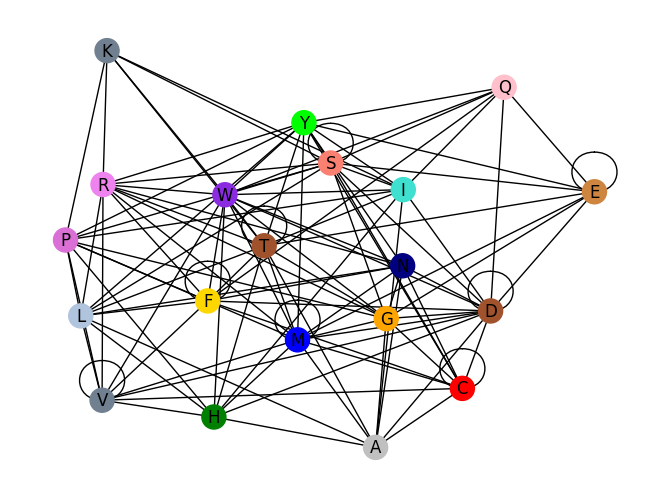

Nodes: ['C', 'V', 'R', 'T', 'E', 'G', 'F', 'W', 'N', 'Y', 'H', 'A', 'D', 'Q', 'K', 'M', 'L', 'S', 'P', 'I']
This graph has 20 nodes.


In [89]:
# Fist group setting
Seq0_data= data[data['labels']==0]
Seq_0=Seq0_data['Sequence'][0]

# Plot the first group
Protein_Network_graph(Seq_0)

# Graph description
Nodes=set(list(Seq_0))
print('Nodes:',list(Nodes))
print('This graph has',len(list(Nodes)), 'nodes.')

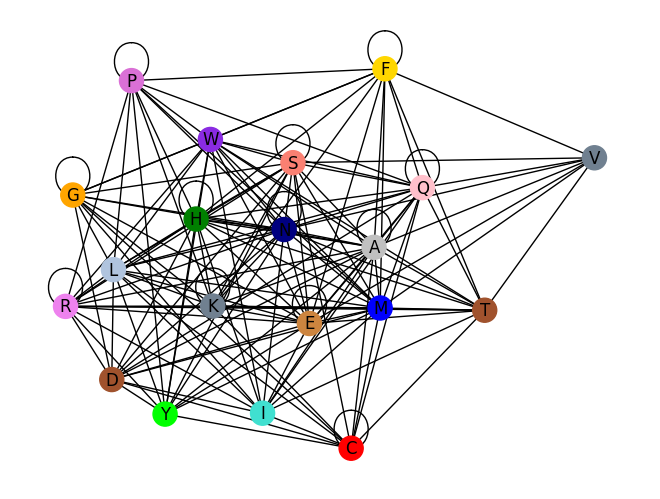

Nodes: ['C', 'V', 'R', 'T', 'E', 'G', 'W', 'F', 'N', 'Y', 'H', 'A', 'D', 'Q', 'K', 'M', 'L', 'S', 'P', 'I']
This graph has 20 nodes.


In [90]:
# Second group setting
Seq1_data= data[data['labels']==1]
Seq_1 = Seq1_data['Sequence'][1704]
# Plot the second group
Protein_Network_graph(Seq_1)
# Graph description
Nodes=set(list(Seq_1))
print('Nodes:',list(Nodes))
print('This graph has',len(list(Nodes)), 'nodes.')

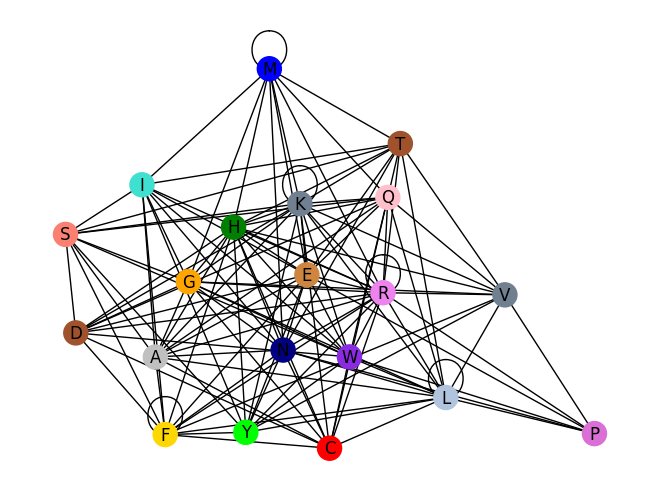

Nodes: ['C', 'V', 'R', 'T', 'E', 'G', 'W', 'F', 'N', 'Y', 'H', 'A', 'D', 'Q', 'K', 'M', 'L', 'S', 'P', 'I']
This graph has 20 nodes.


In [91]:
# Third group setting
Seq2_data= data[data['labels']==2]
Seq_2 = Seq2_data['Sequence'][1711]
# Plot the third group
Protein_Network_graph(Seq_2)
# Graph description
Nodes=set(list(Seq_2))
print('Nodes:',list(Nodes))
print('This graph has',len(list(Nodes)), 'nodes.')

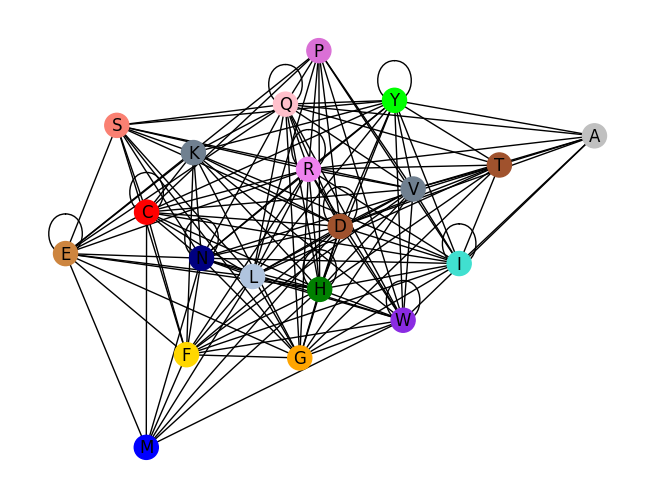

Nodes: ['C', 'V', 'R', 'T', 'E', 'G', 'W', 'F', 'N', 'Y', 'H', 'A', 'D', 'Q', 'K', 'M', 'L', 'S', 'P', 'I']
This graph has 20 nodes.


In [92]:
# Fourth group setting
Seq3_data= data[data['labels']==3]
Seq_3 = Seq3_data['Sequence'][2196]
# Plot the Fourth group
Protein_Network_graph(Seq_3)
# Graph description
Nodes=set(list(Seq_3))
print('Nodes:',list(Nodes))
print('This graph has',len(list(Nodes)), 'nodes.')

Our analysis suggests that our dataset contains 10 major families of proteins.